In [1]:
import pandas as pd
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis

import seaborn as sns
import matplotlib.pylab as plt


#display settings
pd.set_option('display.max_columns', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option("display.max_colwidth", False)


# Training data 

In [2]:
#Get data
df = pd.read_excel('Data/LLPSDB/LLPS.xls')
#Choose only single-protein systems
df = df[df['Protein ID'].str.len() == 5]
df = df[(df['Components type']== 'protein(1)') | (df['Components type']== 'Protein(1)')]

#Choose only naturally occuring proteins
df = df[df['Protein type (N/D)'] == 'N']

#Ignore data with mutations or PMTs or from repreat-proteins and at non-atmopsheric pressure
df = df[df['Mutation'] =='-']
df = df[df['PTM']=='-']
df = df[df['Repeat']=='-']
df = df[df['Pressure']=='-']
#Choose only individual experiments
df = df[df['Phase diagram'].isna()]


#Get construct sequence
df['Extract_construct_sequence'] = df['Sequence'].str.split('\n').str[1:]
Construct_sequences = []
for i in range(0, df.shape[0]):
    Construct_sequences.append(df['Extract_construct_sequence'][i:i+1].to_string(index = False).translate(str.maketrans({',': '', '[': '', ']': '', ' ': ''})))
df['Construct_sequence'] = np.asarray(Construct_sequences)
df = df.drop(columns=['Extract_construct_sequence'])

#Manually correct a concentration that is in w/v format
df['Solute concentration'] = df['Solute concentration'].str.replace('1:19 w/v 5HT1A', '0.05 mg/ml 5HT1A')
#And remove the enrtries where it is unclear what the concentration is
#df = df[df['Sequence length'] != '[Tau K25]:N/A']
df = df[df['Construct_sequence'] != '']

#Extract solute concentration
#First, value
df['solute_split_1'] = df['Solute concentration'].str.split(" \[").str[0]
df['solute_split_1'] = df['solute_split_1'].str.replace('≥', '').str.replace('≤', '').str.replace('＜', '').str.replace('>', '')
df['solute_split_1'] = df['solute_split_1'].str.rstrip()
df['solute_split_1'] = df['solute_split_1'].str.lstrip()
df['solute_concentration'] = df['solute_split_1'].str.split(' ').str[0]
#Replace ranges with average concentrations
df['solute_concentration'] = np.where(df['solute_concentration'].str.contains('-'), 
                    0.5*(df['solute_concentration'].str.split('-').str[0].astype(float) + df['solute_concentration'].str.split('-').str[0].astype(float)),
                    df['solute_concentration'])

#Next, unit
df['solute_conc_unit'] = df['solute_split_1'].str.split(' ').str[1]
df = df.drop(columns = ['solute_split_1'])
#Convert molar concentrations to mass (all that are given as mass have units of mgmL-1)
df['Mw'] = [ProteinAnalysis(x).molecular_weight() for x in df['Construct_sequence']]
df['conc_to_uM_conversion_factor'] = 1
df['conc_to_uM_conversion_factor'] = np.where(df['solute_conc_unit'] == 'µM', 1, df['conc_to_uM_conversion_factor'])
df['conc_to_uM_conversion_factor'] = np.where(df['solute_conc_unit'] == 'uM', 1, df['conc_to_uM_conversion_factor'])
df['conc_to_uM_conversion_factor'] = np.where(df['solute_conc_unit'] == 'nM', 0.001, df['conc_to_uM_conversion_factor'])
df['conc_to_uM_conversion_factor'] = np.where(df['solute_conc_unit'] == 'mM', 1000, df['conc_to_uM_conversion_factor'])
df['conc_to_uM_conversion_factor'] = np.where(df['solute_conc_unit'] == 'mg/ml',
                                    10**6/df['Mw'], df['conc_to_uM_conversion_factor'])
df['conc_to_uM_conversion_factor'] = np.where(df['solute_conc_unit'] == 'mg/mL',
                                    10**6/df['Mw'], df['conc_to_uM_conversion_factor'])

#Final conversion
df['conc_uM_final'] = df['conc_to_uM_conversion_factor'].astype(float) * df['solute_concentration'].astype(float)


In [3]:
#Create LLPS_plus and LLPS_minus
df_yes = df[df['Phase separation'] == 'Yes']
df_yes_grouped = df_yes.groupby('Construct_sequence')['conc_uM_final'].mean()
df_yes_lower_than_hundred = df_yes_grouped[df_yes_grouped <= 100]
llps_plus = pd.DataFrame({'Sequence': df_yes_lower_than_hundred.index})
llps_plus[llps_plus['Sequence'] != '']

all_sequences = pd.DataFrame({'Sequence': df['Construct_sequence'].unique()})
llps_minus = all_sequences[~all_sequences['Sequence'].isin(llps_plus['Sequence'])]

#Include Uniprot IDs:
seq_dict = dict(zip(df['Construct_sequence'], df['Protein ID']))
proteins = pd.read_excel('Data/LLPSDB/protein.xls')
id_dict = dict(zip(proteins['PID'], proteins['Uniprot ID']))

llps_plus['PID'] = llps_plus['Sequence'].map(seq_dict)
llps_plus['Uniprot_ID'] = llps_plus['PID'].map(id_dict)
llps_plus = llps_plus.drop(columns = ['PID'])
llps_minus['PID'] = llps_minus['Sequence'].map(seq_dict)
llps_minus['Uniprot_ID'] = llps_minus['PID'].map(id_dict)
llps_minus = llps_minus.drop(columns = ['PID'])
llps_plus.to_csv('Data/llps_plus.csv', index = False)
llps_minus.to_csv('Data/llps_minus.csv', index = False)


<ipython-input-3-6fbc86f5ca4f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llps_minus['PID'] = llps_minus['Sequence'].map(seq_dict)
<ipython-input-3-6fbc86f5ca4f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llps_minus['Uniprot_ID'] = llps_minus['PID'].map(id_dict)


In [4]:
conc_df = pd.DataFrame({'c_sat': df_yes.groupby('Construct_sequence').mean()['conc_uM_final'],
                       'Sequence': list(df_yes.groupby('Construct_sequence').mean().index)})
combined = pd.read_csv('Features/training_data_features.csv')
sec_csat_dict = dict(zip(conc_df['Sequence'], conc_df['c_sat']))
combined['c_sat']  = combined['Sequence'].map(sec_csat_dict)

swissprot_all = pd.read_csv('Features/swissprot_features.csv')
df_comb = pd.concat([swissprot_all, combined], axis = 0)

/Users/kadiliissaar/anaconda3/envs/prot/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


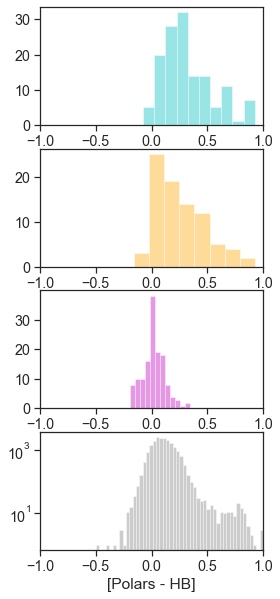

In [5]:
df_comb['diff'] = df_comb['Polar_frac'] + df_comb['Arom_frac'] - df_comb['HB_frac'] 
sns.set(rc={'figure.figsize':(6, 5)}); sns.set(font_scale = 1.3)
sns.set_style("white"); sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})
df1 = df_comb['diff'][df_comb['Category'] == 'LLPS+']
df2 = df_comb['diff'][df_comb['Category'] == 'LLPS-']
df3 = df_comb['diff'][df_comb['Category'] == 'PDB*']
df4 = df_comb['diff'][df_comb['Category'] == 'Swiss-Prot']

f, ax = plt.subplots(4, 1, figsize = (4, 10))
sns.distplot(df1, color = '#00BFBF', kde = False, label = 'LLPS+', ax=ax.flat[0])
ax.flat[0].set_xlim([-1, 1])
sns.distplot(df2, color = '#FFA500', kde = False, label = 'LLPS-', ax=ax.flat[1])
ax.flat[1].set_xlim([-1, 1])
sns.distplot(df3, color = '#BF00BF', kde = False, label = 'PDB*', ax=ax.flat[2])
ax.flat[2].set_xlim([-1, 1])
sns.distplot(df4, color = '#808080', kde = False, label = 'Swiss-Prot', ax=ax.flat[3])
ax.flat[3].set_xlim([-1, 1])
plt.yscale('log')
plt.xlabel('[Polars - HB]')
plt.show()

/Users/kadiliissaar/anaconda3/envs/prot/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


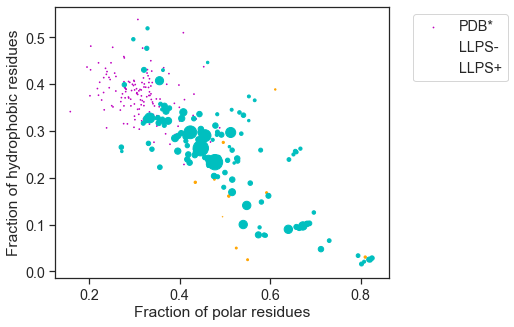

In [6]:
df_comb['c_sat'] = np.where(df_comb['Category'] == 'PDB*', 10000, df_comb['c_sat'] )
df1 = df_comb[df_comb['Category'] == 'LLPS+']
df2 = df_comb[df_comb['Category'] == 'LLPS-']
df3 = df_comb[df_comb['Category'] == 'PDB*']
df = pd.concat([df1, df2, df3])

column1 = 'Polar_frac'
column2 = 'HB_frac'
plt.scatter(df3[column1], df3[column2], s = 1.7**(0 - np.log(df3["c_sat"]) + 8), color = '#BF00BF', label = 'PDB*')
plt.scatter(df2[column1], df2[column2], s = 1.7**(0 - np.log(df2["c_sat"]) + 8), color = '#FFA500', label = 'LLPS-')
plt.scatter(df1[column1], df1[column2], s = 1.7**(0 - np.log(df1["c_sat"]) + 8), color = '#00BFBF' , label = 'LLPS+')
plt.xlabel('Fraction of polar residues')
plt.ylabel('Fraction of hydrophobic residues')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# External data

In [9]:
#LLPS-prone
#Read data
PhaSeDB = pd.read_excel('Data/PhaSeDB/Reviewed Data V1.3.xlsx', sep = '\t')
PhaSeDB = PhaSeDB.drop_duplicates(subset=['UniprotEntry'])
#Correct error
PhaSeDB['UniprotEntry'] = PhaSeDB['UniprotEntry'].replace('P62993\t', 'P62993')

#Filter to human and remove training data
human_SP = pd.read_csv('Features/swissprot_features.csv')
phasedb_human_with_train = PhaSeDB[PhaSeDB['UniprotEntry'].isin(human_SP['Uniprot_ID'])]
train_proteins = pd.read_csv('Features/training_data_features.csv')
phasedb_human = phasedb_human_with_train[phasedb_human_with_train['UniprotEntry'].isin(train_proteins['Uniprot_ID']) == False]

#Filter to remove fully structured and map sequences
di_idr = dict(zip(human_SP['Uniprot_ID'], human_SP['IDR_frac']))
di_seq = dict(zip(human_SP['Uniprot_ID'], human_SP['Sequence']))
phasedb_human['IDR_frac'] = phasedb_human['UniprotEntry'].map(di_idr)
phasedb_human['Sequence'] = phasedb_human['UniprotEntry'].map(di_seq)
pos_test_set = phasedb_human[(phasedb_human['IDR_frac'] >= 0.01)]
pos_test_set[{'Sequence'}].to_csv('Data/positive_test_set.txt', index = False, header = False)

<ipython-input-9-99d07d4b866f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phasedb_human['IDR_frac'] = phasedb_human['UniprotEntry'].map(di_idr)
<ipython-input-9-99d07d4b866f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phasedb_human['Sequence'] = phasedb_human['UniprotEntry'].map(di_seq)


In [10]:
# Non LLPS-prone (sampled from PDB*)
pdb_data_full = pd.read_csv('Data/pdb30.csv', sep = '\t')
pdb_data = pdb_data_full[pdb_data_full['seq'].isin(train_proteins['Sequence']) == False]
pdb_external = pdb_data.sample(n = 161)
pdb_external[{'seq'}].to_csv('Data/negative_test_set.txt', index = False, header = False)